In [1]:
import warnings
#warnings.filterwarnings('ignore')

import sys, os
import importlib.util 

spec = importlib.util.spec_from_file_location("tradetestlib","C:\\Users\\JB\\Desktop\\Alpha\\Repositories\\Modules\\Generic\\TradeTestLib\\tradetestlib\\__init__.py")
tradetestlib = importlib.util.module_from_spec(spec)
sys.modules['tradetestlib'] = tradetestlib
spec.loader.exec_module(tradetestlib)


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib
from datetime import datetime as dt, timedelta 
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint 
from scipy.stats import t 
#import tradetestlib
from tqdm import tqdm
import hurst
import MetaTrader5 as mt5
import statsmodels.tsa.stattools as ts 

from scipy.stats import jarque_bera as jb

import random 
from mean_reversion import Mean_Reversion

### MEAN REVERSION 


In [2]:


def get_data(how = 'symbol', symbol = None):
    
    folder = 'history'
    
    if how == 'symbol':
        path = f"{folder}/{symbol}/{symbol}_m5.csv"
    
    elif how == 'random':
        
        files = os.listdir(folder)
        index = random.randint(0, len(files) - 1)
        sub_folder = f"{folder}/{files[index]}"
        path = f"{sub_folder}/{os.listdir(sub_folder)[0]}"

    else:
        return None

    df = pd.read_csv(path, index_col='time')
    df = df[['open','high','low','close']]
    df.index = pd.to_datetime(df.index)
    
    return df

def get_mt5_data(symbol, tf, start_date = None, end_date = None):
    mt5_data = tradetestlib.MT5_Data()
    
    start_date = dt(2018, 1, 1) if start_date is None else start_date
    end_date = dt(2023, 12, 31) if end_date is None else end_date
    return mt5_data.request_price_data(symbol, tf, 'range', start_date = start_date, end_date = end_date)



### BUILD 

An oscillator is created by taking the Z-Score of the spread between Close Price and Moving Average. Rolling mean and standard deviation are calculated on a defined window. 

Positions and signals are determined when the Z-Score exceeds a defined threshold. 

In [3]:

def build(df, window, fill = True, signal_thresh: int = 3, invert = False):
    
    dataset = df.copy()
    dataset.columns = [c.lower() for c in dataset.columns]
    dataset['returns'] = dataset['close'].diff(1)
    dataset['cumm_returns'] = dataset['returns'].cumsum() 
    dataset = dataset.dropna()

    dataset['position'] = np.nan if fill else 0

    dataset['rolling_mean'] = dataset['close'].rolling(window).mean()

    # Measuring returns as the difference between close price and moving average
    dataset['returns_spread'] = dataset['close'] - dataset['rolling_mean']
    dataset['spread_rolling_std'] = dataset['returns_spread'].rolling(window).std()
    dataset['spread_rolling_mean'] = dataset['returns_spread'].rolling(window).mean()

    # Z Score - absolute spread
    dataset['normalized_spread'] = (dataset['returns_spread'] - dataset['spread_rolling_mean']) / dataset['spread_rolling_std']
    dataset['normalized_spread'] = dataset['normalized_spread'].shift(1) 

    dataset.loc[dataset['normalized_spread'] > signal_thresh, 'position'] = -1 
    dataset.loc[dataset['normalized_spread'] < -signal_thresh, 'position'] = 1
    dataset['position'] = dataset['position'].ffill()

    inversion_factor = -1 if invert else 1 
    dataset['position'] = dataset['position'] * inversion_factor


    dataset = dataset.dropna()

    return dataset


In [4]:
sym_1 = 'USDCAD'
tf = 'm15'

start = dt(2018,1,1)
end = dt(2023,12,31)

#df_1 = get_mt5_data(symbol = sym_1, tf = tf, start_date=start, end_date=end)
df_1 = pd.read_csv('USDCAD_m15.csv', index_col='Date')
df_1.index = pd.to_datetime(df_1.index)
len(df_1)

149184

In [5]:
signal_threshold = 3
built = build(df_1.copy(), window = 50, signal_thresh = signal_threshold, fill = True, invert = False)

Text(0.5, 1.0, 'Z-Score - Spread')

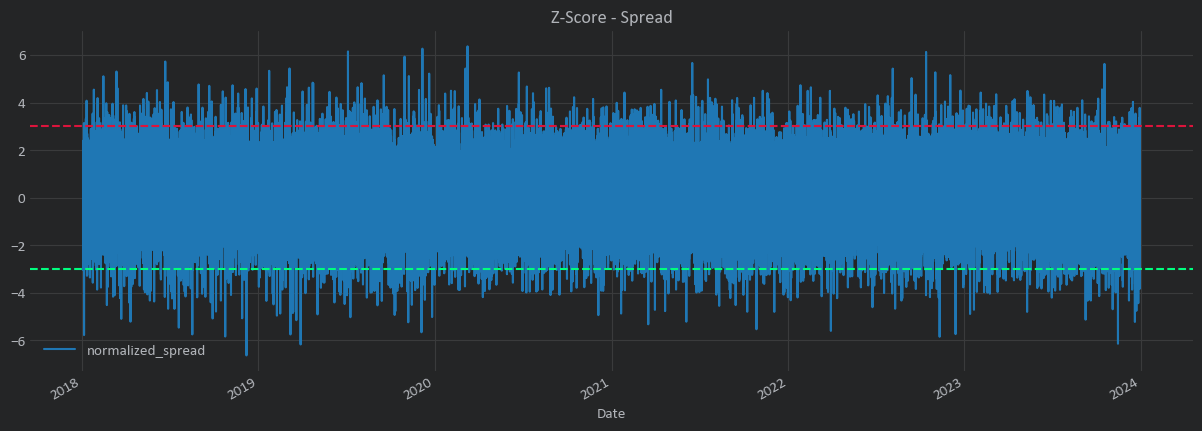

In [6]:
built[['normalized_spread']].plot(figsize = (15, 5))
plt.axhline(signal_threshold, ls = '--', color = 'crimson')
plt.axhline(-signal_threshold, ls = '--', color = 'springgreen')
plt.title('Z-Score - Spread')


In [7]:
def plot_dist(data):
    _, p, _, _ = jarque_bera(data)
    print(f"JB: {p:.3e}")
    print(f"skew: {data.skew():.3f}, kurt: {data.kurt():.3f}")
    sns.displot(data, kde = True, height = 4, aspect = 1.5)
    

In [8]:
sim_cols = ['open', 'high', 'low', 'close','spread', 'position']
sub = built[sim_cols]

In [9]:
sub['new_trade'] = 0
sub.loc[(sub['position'] != sub['position'].shift(-1)), 'new_trade'] = 1
sub['new_trade'] = sub['new_trade'].shift(1)
sub = sub.dropna()
sub['signal'] = (sub['position'] * sub['new_trade']).astype(int)


sub['close_price'] = np.nan
sub.loc[(sub['position'] != sub['position'].shift(-1)), 'close_price'] = sub['close']


sub['close_price'] = sub['close_price'].bfill()
sub['close_price'] = sub['close_price'] * sub['new_trade']

new_position_mask = (sub['position'] != sub['position'].shift(-1))

sub['count'] = sub['new_trade'].cumsum().astype(int)
lowest = sub.groupby('count')['low'].min().to_dict()
highest = sub.groupby('count')['high'].max().to_dict()

sub['lowest'] = sub.loc[sub['signal'] != 0]['count'].map(lowest)
sub['highest'] = sub.loc[sub['signal'] != 0]['count'].map(highest)

sub = sub.fillna(0)

sub['trade_diff'] = (sub['close_price'] - sub['close']) * sub['new_trade'] * sub['position']


In [10]:
#sub.groupby('count')[['count']].count()

Text(0.5, 1.0, 'Strategy Returns')

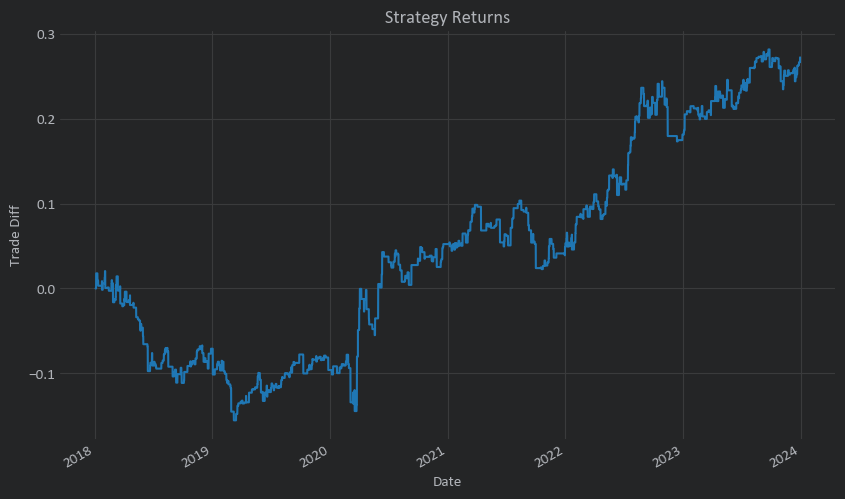

In [59]:
sub['trade_diff'].cumsum().plot(figsize = (10,6))
plt.ylabel('Trade Diff')
plt.title('Strategy Returns')


In [60]:
def filter_data(data, hours_list=[]):
    grouped = data.groupby(data.index.hour)[['trade_diff']].sum().sort_values(by='trade_diff', ascending = False).head(15)

    hours = hours_list.copy() if len(hours_list) != 0 else grouped.index.tolist()

    data.loc[(~data.index.hour.isin(hours)), 'trade_diff'] = 0 
    return data, hours



In [61]:
train_end = dt(2020, 12, 31)

train = sub.loc[sub.index.date <= train_end.date()]
test = sub.loc[sub.index.date > train_end.date()]

test_trades = test.query('signal != 0')['signal'].count()
print("TEST TRADES: ", test_trades)

filtered_train, train_hours = filter_data(train)
filtered_test, test_hours = filter_data(test, train_hours)

print("TRAIN HOURS: ", train_hours)
print("TEST HOURS: ", test_hours)

TEST TRADES:  299
TRAIN HOURS:  [18, 22, 17, 21, 23, 16, 14, 1, 10, 20, 2, 12, 5, 0, 9]
TEST HOURS:  [18, 22, 17, 21, 23, 16, 14, 1, 10, 20, 2, 12, 5, 0, 9]


Text(0.5, 1.0, 'Filtered Train Set')

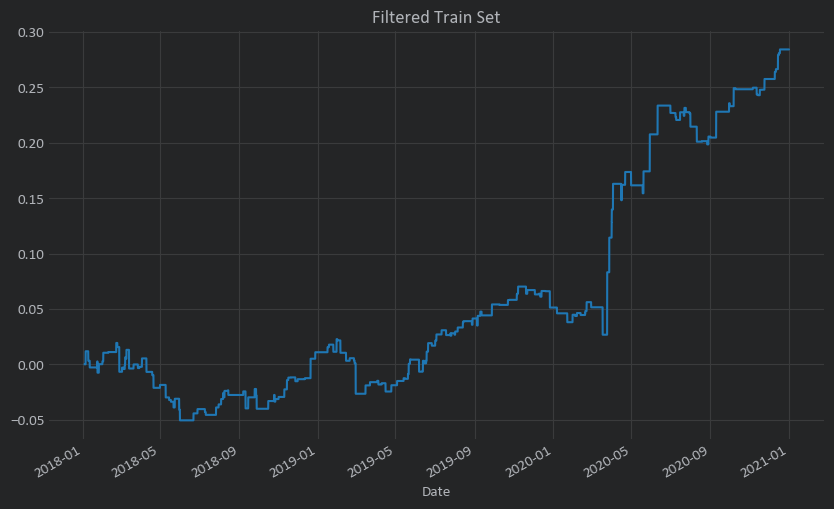

In [62]:
filtered_train['trade_diff'].cumsum().plot(figsize = (10, 6))
plt.title('Filtered Train Set')

Text(0.5, 1.0, 'Filtered Test Set')

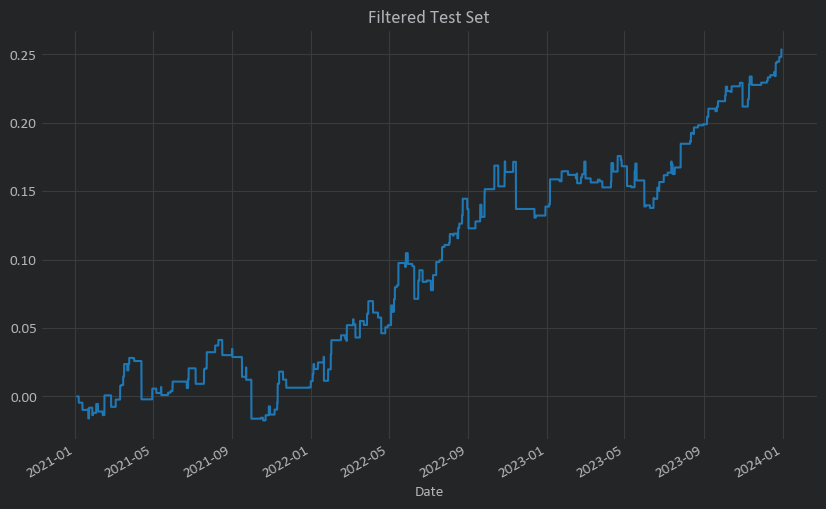

In [63]:
filtered_test['trade_diff'].cumsum().plot(figsize = (10, 6))
plt.title('Filtered Test Set')

In [64]:
lot = 5
loss = 1
hold = 1
mt5.initialize()


sim = tradetestlib.Simulation(
                 sym_1, 
                 tf, 
                 train_raw = train[sim_cols], 
                 test_raw=test[sim_cols], 
                 lot = lot, 
                 starting_balance=100000, 
                 max_loss_pct=loss, 
                 hold_time=hold, 
                 trading_window_start = 1,
                 trading_window_end=23,
                 num_elements = 100,
                 default_figsize=(14,6),
                 trading_type = 'inverting'
                 )

---------- BACKTEST PROPERTIES ----------
Symbol:  USDCAD
Timeframe:  m15
Trade Point:  1e-05
Trade Tick:  0.7435939382222158
Lot Size:  5
Hold Time:  1
Max Loss Pct:  1
Max Loss:  100000
Commission:  35.0
Contract Size:  100000.0
Spread:  1
Starting Balance:  100000
---------- BACKTEST PROPERTIES ----------


In [65]:
sim.test_filtered_summary

,USDCAD_m15_test_filtered
start_date,2021-01-04
end_date,2023-12-29
starting_balance,100000.0
end_balance,161815.378712
mean_profit_points,584.683673
mean_loss_points,726.925926
pts_to_spread,14324.75
lot,5
holdtime,1
max_loss_pct,-10.608906


### Out-of-Sample

Annualized Sharpe Ratio: 0.94


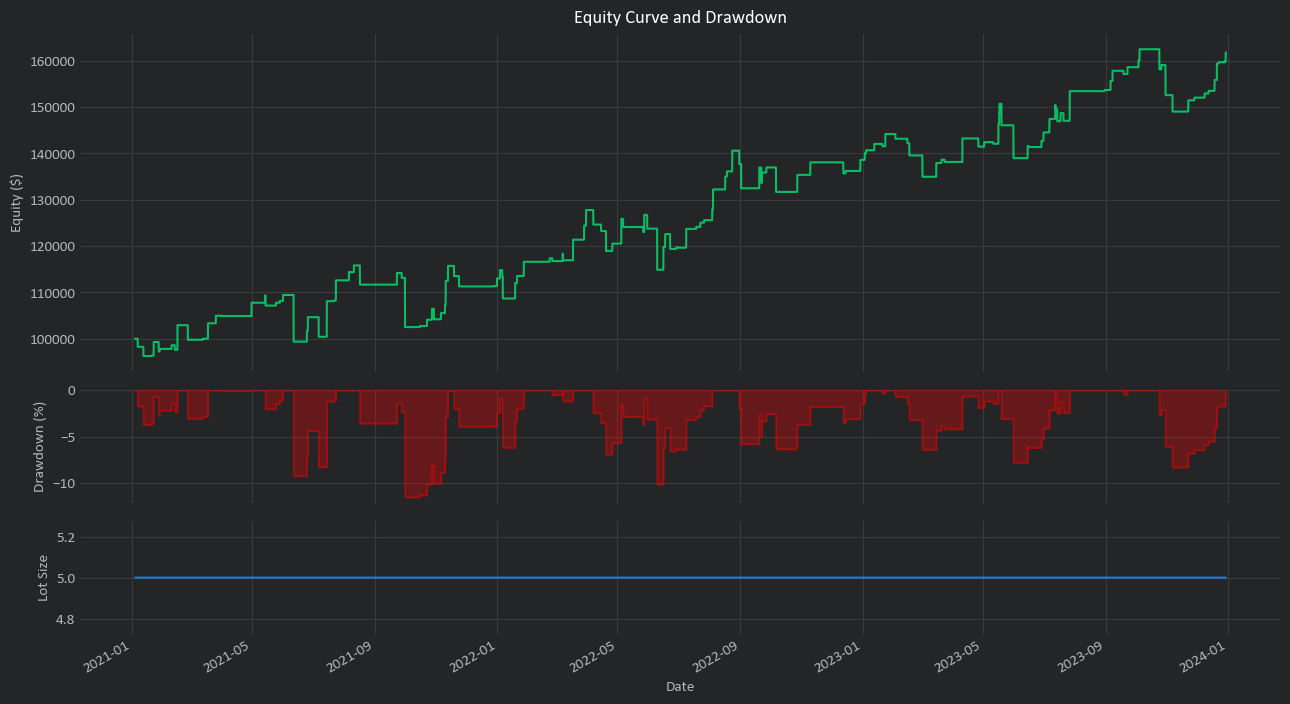

In [69]:
sharpe = sim.test_filtered_evaluation.sharpe_ratio 
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")
sim.plot_equity_curve(sim.test_filtered)

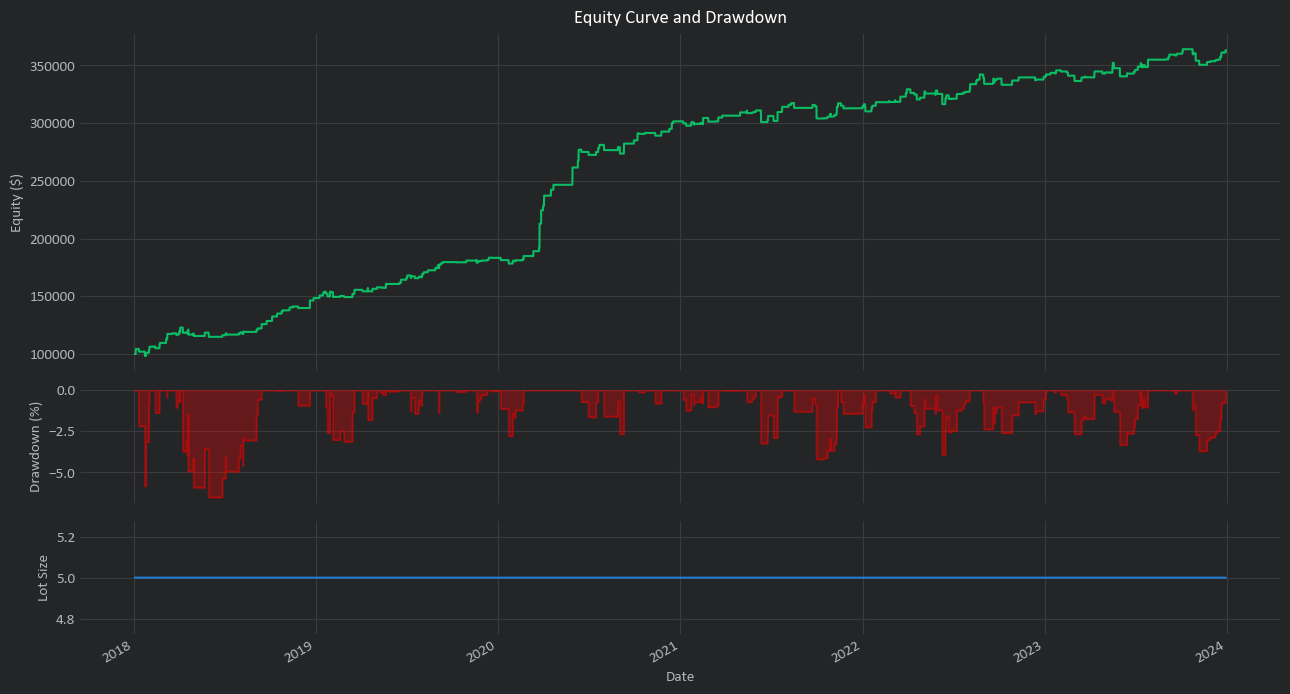

In [ ]:
sim.plot_equity_curve(sim.combined_filtered)

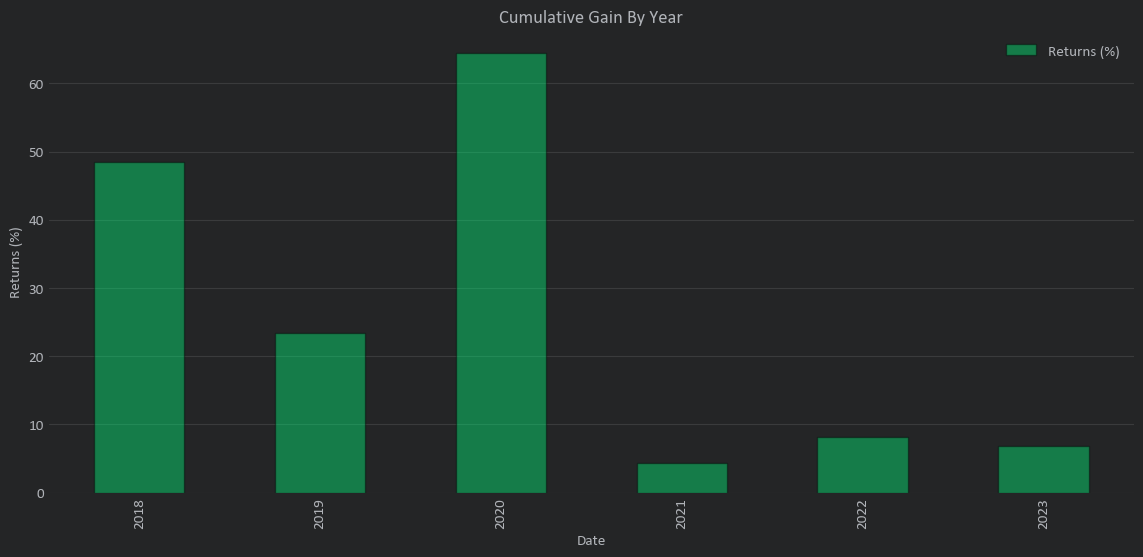

In [70]:
sim.plot_cumulative_gain_by_year()

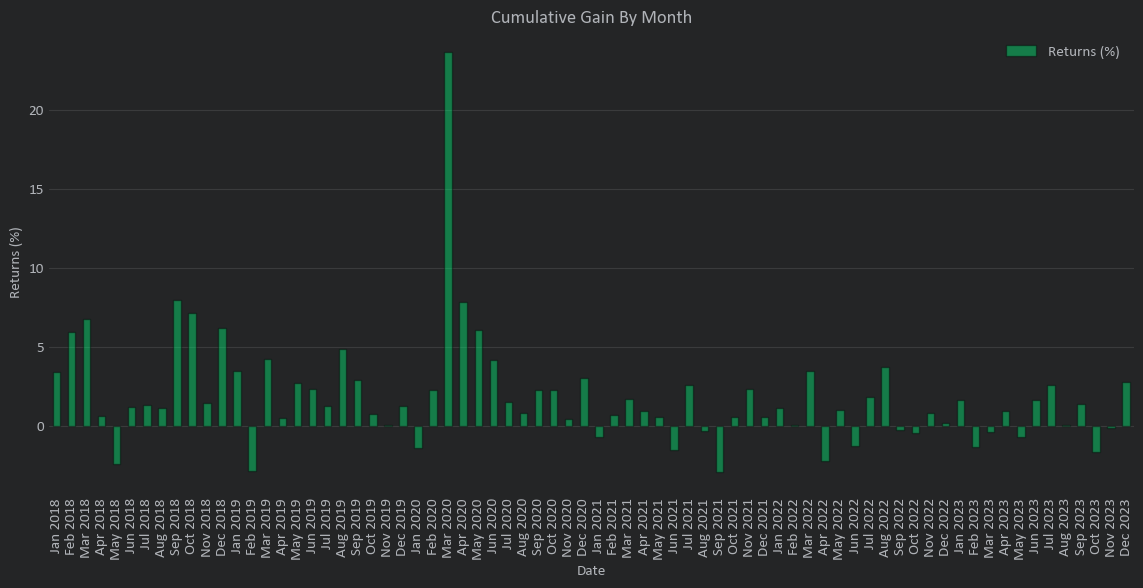

In [71]:
sim.plot_cumulative_gain_by_month()

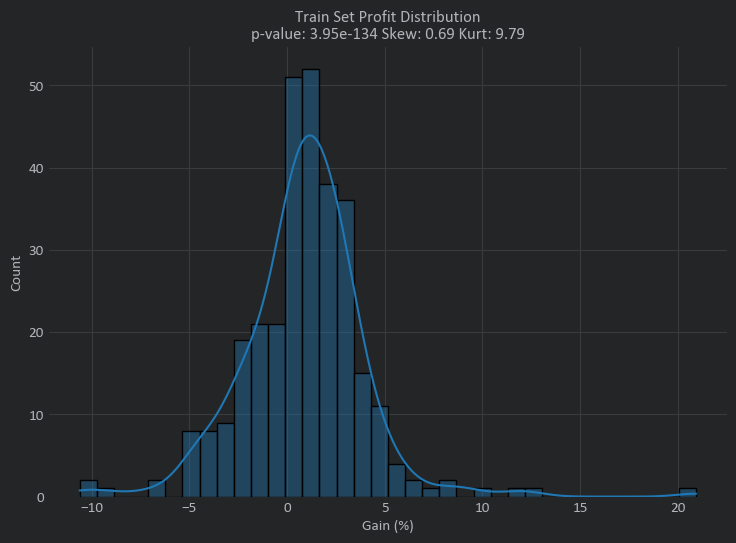

In [72]:
sim.plot_returns_distribution(sim.combined_filtered)

In [73]:
e = tradetestlib.Evaluation()

e.performance_metrics_df(sim.test_filtered)

,Value
cagr,17.505214
expectancy,406.680123
sharpe_ratio,0.938171
profit_factor,0.793804
avg_rrr,0.781492
